In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using MDToolbox
using BenchmarkTools
using EzXML
ENV["COLUMNS"] = 130

130

In [ ]:
cd("/home/ysako/data3_ysako/differentiable/forcefield/mbar_alanine_dipeptide")

In [2]:
pdb_filepath = "./alanine-dipeptide-nowater.pdb"
traj_dir = "./sim_result"
ff_dir = "./sim_result"
njobs = 9

target_traj_path = "./sim_result/sim10/traj_10.dcd"
target_ff_filepath = "./sim_result/sim10/sim_10.xml"

"./sim_result/sim10/sim_10.xml"

In [3]:
slice = 50 # データのスライス
atom_pairs = [5 15] #距離を計算する原子のペア
bandwidth = 0.005
num_points = 100

100

In [4]:
#pythonのmdtrajのインデックスに+1してる
phi_indices = [5, 7, 9, 15]   #二面角ϕ
psi_indices = [7, 9, 15, 17]  #二面角ψ

#xmlファイルでのatom type
phi_atom_type = ["C", "N", "CT", "C"]
psi_atom_type = ["N", "CT", "C", "N"]

4-element Vector{String}:
 "N"
 "CT"
 "C"
 "N"

In [5]:
top = readpdb(pdb_filepath)

#input target traj
ta = mdload(target_traj_path, top=top)
ta = ta[1:slice:end]
phi = compute_dihedral(ta[:,phi_indices[1]], ta[:,phi_indices[2]], ta[:,phi_indices[3]], ta[:,phi_indices[4]]) * π / 180
psi = compute_dihedral(ta[:,psi_indices[1]], ta[:,psi_indices[2]], ta[:,psi_indices[3]], ta[:,psi_indices[4]]) * π / 180
dihedral_target = hcat(phi, psi)
distance_target = vec(compute_distance(ta, atom_pairs) ./ 10) # nmに変換

for i in 1:length(top.atomid)
    println("atomid = $(top.atomid[i]), atomname = $(top.atomname[i])")
end
println()
#sanity check
@show ta[:,vec(atom_pairs)].atomname
@show ta[:, phi_indices].atomname
@show ta[:, psi_indices].atomname

atomid = 1, atomname = HH31
atomid = 2, atomname = CH3
atomid = 3, atomname = HH32
atomid = 4, atomname = HH33
atomid = 5, atomname = C
atomid = 6, atomname = O
atomid = 7, atomname = N
atomid = 8, atomname = H
atomid = 9, atomname = CA
atomid = 10, atomname = HA
atomid = 11, atomname = CB
atomid = 12, atomname = HB1
atomid = 13, atomname = HB2
atomid = 14, atomname = HB3
atomid = 15, atomname = C
atomid = 16, atomname = O
atomid = 17, atomname = N
atomid = 18, atomname = H
atomid = 19, atomname = CH3
atomid = 20, atomname = HH31
atomid = 21, atomname = HH32
atomid = 22, atomname = HH33

(ta[:, vec(atom_pairs)]).atomname = ["C", "C"]
(ta[:, phi_indices]).atomname = ["C", "N", "CA", "C"]
(ta[:, psi_indices]).atomname = ["N", "CA", "C", "N"]


4-element Vector{String}:
 "N"
 "CA"
 "C"
 "N"

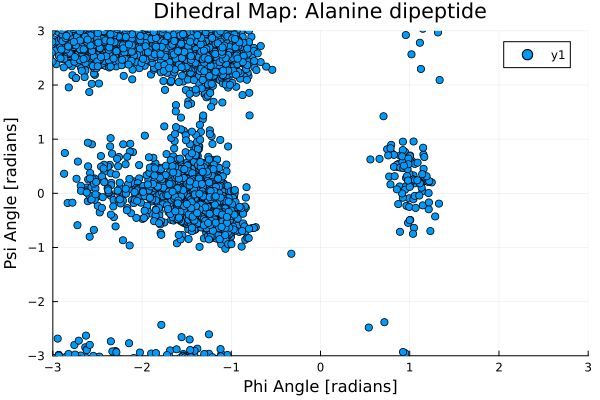

In [6]:
plot(dihedral_target[1:5:end, 1], dihedral_target[1:5:end, 2], st=scatter,
    xlabel="Phi Angle [radians]", ylabel="Psi Angle [radians]", title=("Dihedral Map: Alanine dipeptide"),
    xlim=(-3,3),ylim=(-3,3))

In [7]:
function kde_estimate(data::AbstractVector, kernel; 
        weight::AbstractVector = ones(length(data)), bandwidth=nothing, num_points::Int=100, x_grid = Float64[])
    # If bandwidth is not specified, estimate it using Silverman's rule
    if isnothing(bandwidth)
        n = length(data)
        s = std(data)
        IQR = quantile(data, 0.75) - quantile(data, 0.25)
        @show bandwidth = 0.9 * min(s, IQR / 1.34) / n^(1/5)
    end
    # Compute kernel density estimate
    density_estimate = zeros(num_points)
    # Compute kernel density estimate
    if isempty(x_grid)
        x_grid = range(minimum(data), maximum(data), length=num_points) |> Vector
    end
    
    for i in 1:num_points
        x = x_grid[i]
        kernel_sum = 0.0
        for (val, w) in zip(data, weight)
            kernel_sum += w * kernel((x - val) / bandwidth)
        end
        density_estimate[i] = kernel_sum / sum(weight) / bandwidth
    end
    
    return x_grid, density_estimate
end
function gaussian_kernel(x)
    return exp(-0.5 * x^2) / sqrt(2 * π)
end

gaussian_kernel (generic function with 1 method)

bandwidth = (0.9 * min(s, IQR / 1.34)) / n ^ (1 / 5) = 0.002481950926876428
  0.094039 seconds (68.80 k allocations: 4.941 MiB, 82.66% compilation time)


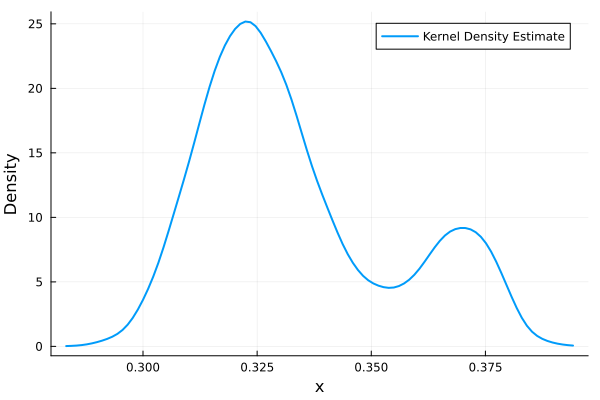

In [8]:
#@time x_grid, density_estimate = kde_estimate(vec(distance_target), gaussian_kernel, bandwidth=bandwidth, num_points=num_points)
@time x_grid, density_estimate = kde_estimate(vec(distance_target), gaussian_kernel, num_points=num_points)
plot(x_grid, density_estimate, label="Kernel Density Estimate", xlabel="x", ylabel="Density", linewidth=2)

In [9]:
function kde_estimate_cpu(data_k, weight_k, kernel::Function; bandwidth=0.0, num_points=1000, x_grid=Float64[])
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = length(data_k[k])
    end
    
    data = vcat(data_k...)
    weight = vcat(weight_k...)

    # If bandwidth is not specified, estimate it using Silverman's rule
    if bandwidth == 0.0
        n = length(data)
        s = std(data)
        IQR = quantile(data, 0.75) - quantile(data, 0.25)
        @show bandwidth = 0.9 * min(s, IQR / 1.34) / n^(1/5)
    end
    
    if isempty(x_grid)
        x_min = minimum(data)
        x_max = maximum(data)
        x_grid = Array(range(x_min, x_max, length=num_points))
    end

    density_estimate = similar(x_grid)
    
    for i in 1:length(x_grid)
        x = x_grid[i]
        kernel_sum = 0.0
        #=
        for j = 1:length(data)
            kernel_sum += weight[j] * kernel((x - data[j]) / bandwidth)
        end
        =#
        kernel_sum = reduce(+, weight .* kernel.((x .- data) ./ bandwidth))
        density_estimate[i] = kernel_sum / sum(weight) / bandwidth
    end
    
    return density_estimate
end


function ChainRulesCore.rrule(::typeof(kde_estimate_cpu), data_k, weight_k, kernel::Function;
        bandwidth=0.0, num_points=1000, x_grid=Float64[])
    density_estimate = kde_estimate_cpu(data_k, weight_k, kernel, bandwidth=bandwidth, num_points=num_points, x_grid=x_grid)
    function kde_estimate_cpu_pullback(dU) 
        K = length(data_k)
        N_k = Array{Int}(undef, K)
        for k in 1:K
            N_k[k] = length(data_k[k])
        end

        data = vcat(data_k...)
        weight = vcat(weight_k...)

        dweight_k = similar(weight_k)
        dweight = similar(weight)

        dweight .= 0.0
        sum_weight = sum(weight)
        for i in 1:length(data)
            for j in 1:length(x_grid)
                dweight[i] += kernel((x_grid[j] - data[i]) / bandwidth) / sum_weight / bandwidth * dU[j]
            end
        end
        index_start = 1
        for k in 1:K
            index_end = index_start + N_k[k] - 1
            dweight_k[k] = dweight[index_start:index_end]
            index_start = index_end + 1
        end

        return NoTangent(), NoTangent(), dweight_k, NoTangent(), NoTangent(), NoTangent(), NoTangent()
    end

    return density_estimate, kde_estimate_cpu_pullback
end

In [10]:
#input traj

dihedral_k = Array{Array{Float64}}(undef, njobs) # 二面角ϕ,ψの値
distance_k = Array{Array{Float64}}(undef, njobs) # 二つの原子間の距離

for i in 1:njobs
    traj_filepath = joinpath(traj_dir, "sim$(i)/traj_$(i).dcd")
    ta = mdload(traj_filepath, top=top)
    ta = ta[1:slice:end]

    phi = compute_dihedral(ta[:,phi_indices[1]], ta[:,phi_indices[2]], ta[:,phi_indices[3]], ta[:,phi_indices[4]]) * π / 180
    psi = compute_dihedral(ta[:,psi_indices[1]], ta[:,psi_indices[2]], ta[:,psi_indices[3]], ta[:,psi_indices[4]]) * π / 180
    dihedral_k[i] = hcat(phi, psi)
    
    distance = vec(compute_distance(ta, atom_pairs) ./ 10) # nmに変換
    distance_k[i] = distance
end

In [11]:
#二面角ϕ,ψに関連するパラメータはn,θ_zero,kの３つ
#最適化を目指すのはk

abstract type AbstractParam end

struct ParamCPU{T<:AbstractFloat}<:AbstractParam
    n::Vector{T}
    theta_zero::Vector{T}
    k::Vector{T}
end

struct Param{T<:AbstractFloat}<:AbstractParam
    n::CuArray{T}
    theta_zero::CuArray{T}
    k::CuArray{T}
end

function init_Param(ff_array::AbstractVector, gpu::Bool=false, T::DataType=Float64)
    n = T[]
    theta_zero = T[]
    k = T[]
    
    for line in ff_array
        #println(line)      
        if(occursin(r"type.*", line[1]))
            continue
        elseif(occursin(r"periodicity.*", line[1]))
            push!(n, parse(T, line[2]))
        elseif(occursin(r"phase.*", line[1]))
            push!(theta_zero, parse(T, line[2]))
        elseif(occursin(r"k.*", line[1]))
            push!(k, parse(T, line[2]))
        else
            println("ERROR")
        end
    end
    
    if(gpu) 
        n = adapt(CuArray, n)
        theta_zero = adapt(CuArray, theta_zero)
        k = adapt(CuArray, k)
        ff_param = Param(n, theta_zero, k)
        return ff_param
    end
    
    ff_param = ParamCPU(n, theta_zero, k)
    return ff_param
end

init_Param (generic function with 3 methods)

In [12]:
#力場ファイルから対象のパラメータを返す関数
function input_ff(ff_filepath; gpu=false::Bool)
    xml = readxml(ff_filepath)
    xmlroot = root(xml)
    
    children = elements(xmlroot)
    children_name = nodename.(children)
    torsion_index = children_name .== "PeriodicTorsionForce"
    torsion = children[torsion_index][1]
    
    phi_atom_type = ["protein-C", "protein-N", "protein-CX", "protein-C"]
    psi_atom_type = ["protein-N", "protein-CX", "protein-C", "protein-N"]
    
    ff_phi = []
    ff_psi = []
    for ff_params in eachelement(torsion)
        params_name = [nodename(i) for i in eachattribute(ff_params)]
        params_content = [nodecontent(i) for i in eachattribute(ff_params)]
        atom_type = [params_content[params_name .== "type$(i)"][1] for i in 1:4]
        #println(atom_type)
        if(atom_type == phi_atom_type)
            ff_phi = [(params_name[i], params_content[i]) for i in 1:length(params_name)]
        end
        if(atom_type == psi_atom_type)
            ff_psi = [(params_name[i], params_content[i]) for i in 1:length(params_name)]
        end
    end
    return init_Param(ff_phi, gpu), init_Param(ff_psi, gpu)
end

input_ff (generic function with 1 method)

In [13]:
ff_phi_k = Array{ParamCPU}(undef, njobs)
ff_psi_k = Array{ParamCPU}(undef, njobs)

for i in 1:njobs
    ff_filepath = joinpath(ff_dir, "sim$(i)/sim_$(i).xml")
    ff_phi_k[i], ff_psi_k[i] = input_ff(ff_filepath)
end

#input target ff
ff_phi_target, ff_psi_target = input_ff(target_ff_filepath)

(ParamCPU{Float64}([4.0, 3.0, 2.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 1.7635709790102643, 1.1958728923516493, 0.0]), ParamCPU{Float64}([4.0, 3.0, 2.0, 1.0], [0.0, 3.141592653589793, 3.141592653589793, 3.141592653589793], [0.0, 2.6051071656990703, 7.70787384716422, 2.0147637829617935]))

In [14]:
#二面角のポテンシャルの計算
@inline function compute_dihedral_energy(theta::AbstractFloat, n::AbstractFloat, 
        theta_zero::AbstractFloat, k::AbstractFloat)
    return k * (1 + cos(n * theta - theta_zero))
end

function sum_compute_dihedral_energy(theta::AbstractFloat, ff_param::AbstractParam)
    return sum(compute_dihedral_energy.(theta, ff_param.n, ff_param.theta_zero, ff_param.k))
end

sum_compute_dihedral_energy (generic function with 1 method)

In [15]:
#compute u_kl
K = njobs
N_k = Array{Int}(undef, K)
for k in 1:K
    N_k[k] = length(distance_k[k])
end
KBT = KB_kcalpermol * 300
beta = Float64(1.0/(KBT))

u_kl = Array{Array{Float64}}(undef, (K, K))
for k in 1:K
    for l in 1:K
        u_kl[k, l] = map(i -> beta * sum_compute_dihedral_energy(dihedral_k[k][i, 1], ff_phi_k[l]) 
            + beta * sum_compute_dihedral_energy(dihedral_k[k][i, 2], ff_psi_k[l]), 1:N_k[k])
    end
end

In [16]:
f_k = Float64.(MDToolbox.mbar(u_kl))

iteration = 1  delta = 2.633584e+00  tol = 1.000000e-08
free energies =  0.000000 0.861239 0.188128 0.942913 0.913298 0.885709 0.763433 0.364268 0.378324

iteration = 2  delta = 8.138141e-02  tol = 1.000000e-08
free energies =  0.000000 0.891414 0.186468 0.969808 0.941021 0.907479 0.793270 0.378190 0.376486

iteration = 3  delta = 4.387015e-03  tol = 1.000000e-08
free energies =  0.000000 0.892632 0.185932 0.970596 0.941742 0.908315 0.794899 0.379308 0.375688

iteration = 4  delta = 3.095264e-04  tol = 1.000000e-08
free energies =  0.000000 0.892694 0.185873 0.970614 0.941747 0.908359 0.795014 0.379410 0.375596

iteration = 5  delta = 2.557427e-05  tol = 1.000000e-08
free energies =  0.000000 0.892698 0.185867 0.970614 0.941746 0.908361 0.795024 0.379420 0.375587

iteration = 6  delta = 2.381839e-06  tol = 1.000000e-08
free energies =  0.000000 0.892698 0.185866 0.970614 0.941745 0.908362 0.795025 0.379421 0.375586

iteration = 7  delta = 2.220382e-07  tol = 1.000000e-08
free energies 

9-element Vector{Float64}:
 0.0
 0.8926979811075448
 0.18586608676207297
 0.9706142271001273
 0.9417453273224282
 0.9083617597163087
 0.79502478355058
 0.3794207353406784
 0.3755861109098532

In [17]:
function compute_u_k_cpu(beta::T, dihedral_k, n_phi, theta_zero_phi,
        k_phi, n_psi, theta_zero_psi, k_psi) where {T}
    
    K = length(dihedral_k)
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = size(dihedral_k[k], 1)
    end

    u_k = Vector{Vector{T}}(undef, K)
    for k in 1:K
        u_k[k] = zeros(T, N_k[k])

        for n in 1:N_k[k]
            for j in 1:length(k_phi)
                u_k[k][n] += beta * compute_dihedral_energy(dihedral_k[k][n, 1], n_phi[j], theta_zero_phi[j], k_phi[j])
            end
            for j in 1:length(k_psi)
                u_k[k][n] += beta * compute_dihedral_energy(dihedral_k[k][n, 2], n_psi[j], theta_zero_psi[j], k_psi[j])
            end
        end
    end
    return u_k
end

function ChainRulesCore.rrule(::typeof(compute_u_k_cpu), beta, dihedral_k, n_phi, theta_zero_phi,
        k_phi, n_psi, theta_zero_psi, k_psi)
    K = length(dihedral_k)
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = size(dihedral_k[k], 1)
    end

    u_k = compute_u_k_cpu(beta, dihedral_k, n_phi, theta_zero_phi,
        k_phi, n_psi, theta_zero_psi, k_psi)

    function compute_u_k_pullback(dU)

        dk_phi = similar(k_phi)
        dk_psi = similar(k_psi)
        dk_phi .= 0.0
        dk_psi .= 0.0

        for k in 1:K
            for i in 1:length(k_phi)
                for n in 1:N_k[k]
                    dk_phi[i] += beta * (1.0 + cos(n_phi[i] * dihedral_k[k][n, 1] - theta_zero_phi[i])) * dU[k][n]
                end
            end
        end

        for k in 1:K
            for i in 1:length(k_psi)
                for n in 1:N_k[k]
                    dk_psi[i] += beta * (1.0 + cos(n_psi[i] * dihedral_k[k][n, 2] - theta_zero_psi[i])) * dU[k][n]
                end
            end
        end

        #println(dk_phi)
        return NoTangent(), NoTangent(), NoTangent(), NoTangent(), NoTangent(), dk_phi, NoTangent(), NoTangent(), dk_psi
    end

    return u_k, compute_u_k_pullback
end

In [18]:
function compute_distribution_property(A_k, dihedral_k, f_k, u_kl, beta, 
        n_phi, theta_zero_phi, k_phi, n_psi, theta_zero_psi, k_psi)
    K = size(A_k, 1)
    u_k = compute_u_k_cpu(beta, dihedral_k, n_phi, theta_zero_phi,
        k_phi, n_psi, theta_zero_psi, k_psi)
    w_k = mbar_weight(u_kl, f_k, u_k)
    
    density_estimate = kde_estimate_cpu(A_k, w_k, gaussian_kernel, x_grid=x_grid, bandwidth=bandwidth)
    #density_estimate = kde_estimate_cpu(A_k, w_k, gaussian_kernel, x_grid=x_grid)
    return density_estimate
end

compute_distribution_property (generic function with 1 method)

In [19]:
# 確率分布を規格化する関数
function normalize(p)
    return p / sum(p)
end

# KLダイバージェンスを計算する関数
function kl_divergence(p, q)
    # 分布を規格化
    p = normalize(p)
    q = normalize(q)
    
    # KLダイバージェンスを計算
    return sum(p .* log.(p ./ q))
end

function ChainRulesCore.rrule(::typeof(kl_divergence), p, q)
    # 元の関数の値
    y = kl_divergence(p, q)

    # 微分ルール
    function kl_divergence_pullback(Δ)
        p = normalize(p)
        q = normalize(q)
        ∂p = Δ * (log.(p ./ q) .+ 1 .- sum(p .* log.(p ./ q)))
        ∂q = -Δ * (p ./ q) ./ length(q)
        return NoTangent(), ∂p, ∂q
    end

    return y, kl_divergence_pullback
end

In [20]:
X_train = distance_k #距離の軌跡
_, y_train = kde_estimate(distance_target, gaussian_kernel, x_grid=x_grid) #ターゲットの距離の分布

struct Energy{T<:AbstractArray}
    P::T #P[1] = k_phi, P[2] = k_psi
end

Flux.@functor Energy (P,)

(m::Energy)(X::AbstractArray) = compute_distribution_property(X, dihedral_k, f_k,
    u_kl, beta, ff_phi_target.n, ff_phi_target.theta_zero, m.P[1],
    ff_psi_target.n, ff_psi_target.theta_zero, m.P[2])

loss(x, y) = kl_divergence(x, y)

bandwidth = (0.9 * min(s, IQR / 1.34)) / n ^ (1 / 5) = 0.002481950926876428


loss (generic function with 1 method)

In [21]:
#sanity check
m = Energy([ff_phi_target.k, ff_psi_target.k])
loss(m(X_train), y_train)

0.02978473108582981

In [22]:
m = Energy([deepcopy(ff_phi_k[1].k), deepcopy(ff_psi_k[1].k)])
loss(m(X_train), y_train)

0.009945019563536606

In [23]:
g = gradient(m -> loss(m(X_train), y_train), m)[1]

(P = [[-1618.4850326641533, -1045.738840463197, -695.4488116647126, -1489.410490453653], [-1431.1416241284269, -1483.6512977880795, -678.0062279766121, -1915.2920565062097]],)

In [24]:
k_phi_estimated_array = []
k_psi_estimated_array = []
n_eff_array = []

Any[]

In [25]:
function print_progress(epoch, loss, m)
    println("Epoch: $(epoch), loss : $(loss)")
end

print_progress (generic function with 1 method)

In [ ]:
loss_train = []
nepoch = 50
learning_rate = 1e-3
println("Initial loss: $(loss(m(X_train), y_train))")
println("Initial param: $(m.P[1])")

m = Energy([deepcopy(ff_phi_k[1].k), deepcopy(ff_psi_k[1].k)])
t = Flux.Optimisers.setup(Adam(learning_rate), m)
loss_train = []
for epoch in 1:nepoch
    g = gradient(m -> loss(m(X_train), y_train), m)[1]
    Flux.Optimisers.update!(t, m, g)

    L = loss(m(X_train), y_train)
    push!(loss_train, L)

    push!(k_phi_estimated_array, deepcopy(m.P[1]))
    push!(k_psi_estimated_array, deepcopy(m.P[2]))

    if (epoch % (nepoch / 10) == 0)
        print_progress(epoch, L, m)
        println(m.P[1])
    end
end

Initial loss: 0.009945019563536606
Initial param: [0.0, 1.8102641460724014, 1.3316859456735661, 0.0]
Epoch: 5, loss : 0.009741310656482588
[0.004999939799739846, 1.8152636276630536, 1.3366856469005879, 0.005000306745960893]
Epoch: 10, loss : 0.009549005169411293
[0.009999553856596701, 1.820260284981675, 1.3416837235471224, 0.01000227571351418]
Epoch: 15, loss : 0.00936827631365174
[0.014998566468856209, 1.8252516875655869, 1.3466787874781727, 0.015007313633233486]
Epoch: 20, loss : 0.009199208146405529
[0.019996732761667826, 1.8302356550338703, 1.3516696070339875, 0.020016657228255512]
Epoch: 25, loss : 0.009041798345362473
[0.024993844537194096, 1.8352103312533188, 1.3566551510519234, 0.02503133266086441]
Epoch: 30, loss : 0.00889596768531575
[0.02998973135829979, 1.840174212105266, 1.361634604825808, 0.030052143320653257]
Epoch: 35, loss : 0.008761573435051424

In [ ]:
plot(loss_train)

In [ ]:
phi_dif = map(i -> (k_phi_estimated_array[i] - ff_phi_target.k) .^ 2, 1:nepoch) |> cpu
psi_dif = map(i -> (k_psi_estimated_array[i] - ff_psi_target.k) .^ 2, 1:nepoch) |> cpu

#二乗誤差
phi_squared_error = map(x -> sum(x), phi_dif)
psi_squared_error = map(x -> sum(x), psi_dif)

phi_dif = [[phi_dif[j][i] for j in 1:nepoch] for i in 1:size(ff_phi_target.k, 1)]
psi_dif = [[psi_dif[j][i] for j in 1:nepoch] for i in 1:size(ff_psi_target.k, 1)]

plot(phi_squared_error, xlabel="Epoch", title="Phi Squared Error")

In [ ]:
plot(psi_squared_error, xlabel="Epoch", title="Psi Squared Error")

In [ ]:
#k_phiと正解の二乗誤差
plt = []
for i in 1:size(ff_phi_target.k, 1)
    tmp = plot()
    plot!(tmp, phi_dif[i], title="k$i")
    push!(plt, tmp)
end
tmp = plot()
plot!(tmp, loss_train, title="Loss")
push!(plt, tmp)

plot(plt...)

In [ ]:
#k_psiと正解の二乗誤差
plt = []
for i in 1:size(ff_psi_target.k, 1)
    tmp = plot()
    plot!(tmp, psi_dif[i], title="k$i")
    push!(plt, tmp)
end
tmp = plot()
plot!(tmp, loss_train, title="Loss")
push!(plt, tmp)

plot(plt...)